<a href="https://colab.research.google.com/github/MarceloPiemonteRibeiro/learning-Machine-learning/blob/main/Optimization/Choosing_parameters_to_optimize_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: [Allura course](https://cursos.alura.com.br/course/machine-learning-otimizacao-de-modelos-atraves-de-hiperparametros) about ML, overfit and hiper parameters

# Data and models perfomed in the notebook Cross_Validation_Optimization

In [1]:
!pip install graphviz==0.9
!pip install pydot
!pip install seaborn==0.11.2
!apt-get install grapviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package grapviz


import data

In [2]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Sort data ascendent - this would affect the model if nothing is done

In [3]:
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


Use dummy classifier to perform a baseline. It uses the proportion of 0 and 1 to guess. Below also cross_validate was used

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy with dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy with dummy stratified, 10 = [58.00, 58.00]


Use a decision tree also as a second baseline

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy with cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy with cross validation, 10 = [73.83, 77.73]


Add a column indicating the cars' models (could be an extra column indicating the cars' cluster). This extra column is a categorical variable.

In [6]:
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


This extra column was not used as an X (input, feature) variable to predict but used to group the data, so to prepare the algorithm to new data

Function below to summarize performance

In [7]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy avg %.2f" % media)
  print("Interval [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Create group Kfold that groups the data by the cars' model (created above)

Instead of decision tree classifier algorithm, use SVC algorithm

In [8]:
# GroupKFold in StandardScaler and SVC
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 76.68
Interval [74.28, 79.08]


Use Decision tree classifier now

In [9]:
# GroupKFold now 

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 75.78
Interval [73.67, 77.90]


Visualize

We fitted above 10 models, to visualize which one we want to use? None of them. We trained 10 times to see how good it would behave in the real world. Now, to really use it we need to train it with our X and Y train and test, so add the line modelo.fit(x_azar, y_azar) in the chunk below

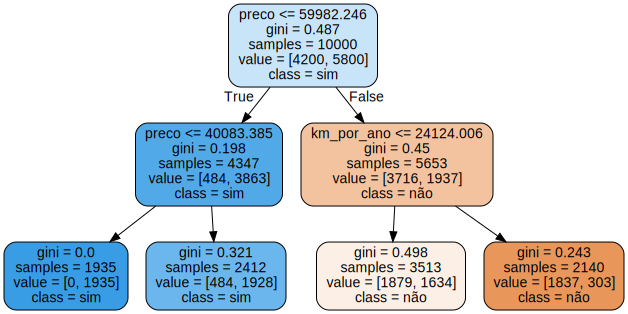

In [10]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

You can increase the Decision tree depth to 3 for example

In [11]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 78.67
Interval [76.40, 80.94]


See that the accuracy is better when using depth=3

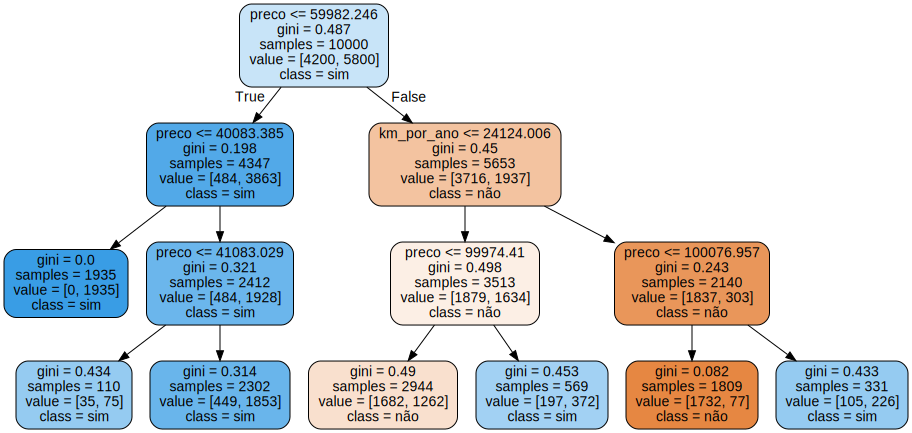

In [12]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

How about using depth=10?

In [13]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy avg 77.19
Interval [75.26, 79.13]


Not necessarily a higher depth reflects a better accuracy, with depth=10 worst accuracy.

# How we choose the algorithms parameters (e.g., depth from tree classifier) to optimize our estimators?

Hyper-parameters are those parameters we choose (e.g., set depth=3 in our decision tree classifier) before trainning (running) the model.

## Testing parameters (one dimension)

### Max depth Decision Tree classifier

Instead of choosing your max_depth you can test in your algorithm all different parameters.

In [14]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth): # define a function to perform our decision tree model
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
  print("max_depth = %d, mean =%.2f" % (max_depth, results['test_score'].mean() * 100)) # if you exclude this line you will have more than the mean

for i in range (1, 33): # run the algorithm using max_depth =1 to =33
      roda_arvore_de_decisao(i)

max_depth = 1, mean =75.78
max_depth = 2, mean =75.78
max_depth = 3, mean =78.67
max_depth = 4, mean =78.63
max_depth = 5, mean =78.56
max_depth = 6, mean =78.12
max_depth = 7, mean =77.96
max_depth = 8, mean =77.86
max_depth = 9, mean =77.38
max_depth = 10, mean =77.19
max_depth = 11, mean =76.97
max_depth = 12, mean =76.49
max_depth = 13, mean =75.81
max_depth = 14, mean =75.66
max_depth = 15, mean =75.16
max_depth = 16, mean =75.11
max_depth = 17, mean =74.74
max_depth = 18, mean =74.33
max_depth = 19, mean =74.34
max_depth = 20, mean =74.22
max_depth = 21, mean =73.80
max_depth = 22, mean =73.81
max_depth = 23, mean =73.38
max_depth = 24, mean =73.43
max_depth = 25, mean =73.14
max_depth = 26, mean =73.04
max_depth = 27, mean =72.91
max_depth = 28, mean =72.66
max_depth = 29, mean =72.73
max_depth = 30, mean =72.81
max_depth = 31, mean =72.86
max_depth = 32, mean =72.52


See that with a higher max_depth the performance wasn't better. 

The above code run the algorithm in our test data. A decision tree with a high max_depth becomes very attached to the train dataset and performs worst when new data is introduced (when model is ran in the test data). Attached in the sense that it captures all the specificities of the train data but becomes rigid and cannot adapt and interpret well new data (our test). 

See that this is happening below, with the algorithm getting better and better when fitted to the train data but not to the test data.

In [15]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  print("Arvore max_depth = %d, fitted to train data = %.2f, fitted to test data = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))



for i in range (1, 33):
      roda_arvore_de_decisao(i)

Arvore max_depth = 1, fitted to train data = 75.79, fitted to test data = 75.78,
Arvore max_depth = 2, fitted to train data = 75.79, fitted to test data = 75.78,
Arvore max_depth = 3, fitted to train data = 78.75, fitted to test data = 78.67,
Arvore max_depth = 4, fitted to train data = 78.79, fitted to test data = 78.63,
Arvore max_depth = 5, fitted to train data = 78.94, fitted to test data = 78.56,
Arvore max_depth = 6, fitted to train data = 79.17, fitted to test data = 78.12,
Arvore max_depth = 7, fitted to train data = 79.50, fitted to test data = 77.96,
Arvore max_depth = 8, fitted to train data = 79.89, fitted to test data = 77.86,
Arvore max_depth = 9, fitted to train data = 80.46, fitted to test data = 77.38,
Arvore max_depth = 10, fitted to train data = 81.16, fitted to test data = 77.19,
Arvore max_depth = 11, fitted to train data = 82.03, fitted to test data = 76.97,
Arvore max_depth = 12, fitted to train data = 82.89, fitted to test data = 76.49,
Arvore max_depth = 13, fi

See that the algorithm gets better with higher max_depth only when fitted to the train data.

Visualize better

In [16]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth, train_score, test_score]
  return tabela

resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)] # it rund the function for each i and returns the table
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"]) # transform in a data frame
resultados.head(33)

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204


Now you can graph your dataframe above: see that you have overfit in the train data (blue line) but the opposite in the test data

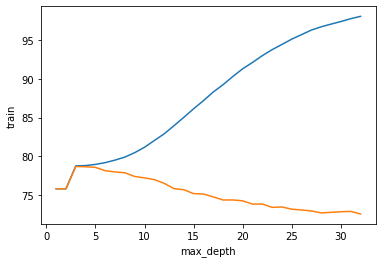

In [17]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)

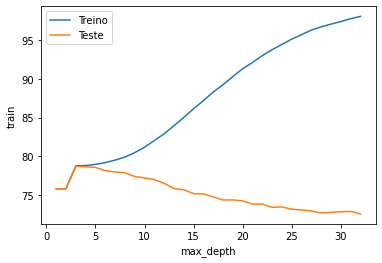

In [18]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

Our best decision trees are:

In [19]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


## Testing parameters (two dimensions)

### Min sample leaf

If you see tha tree graph, you will verifiy the *samples*. The higher the max_depth the lower will be the *samples* in the last (bottom) leaves/ramifications. The *min_samples* is a parameter from the Decision tree classifier that determines this last ramification *samples*. 
How to determine this value?

So far we tested only max_depth, now we will test two dimensions, max_depth and min_sample_leaf. So a matrix with the combination of these parameters will be tested (e.g., max_depth=1 and min_sample_leaf=1, max_depth=1 and min_sample_leaf=2, ...). See that in practice this could take time to run!

The below code will take time because will explore all the range i

In [20]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf) # see we added the parameter min_sample_leaf here
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score] # see we also added min_sample_leaf here
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in range(1,33): 
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 3, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 4, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 5, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 6, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 7, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 8, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 9, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 10, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 11, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 12, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 13, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_

,max_depth,min_samples_leaf,train,test
0,1,1,75.791169,75.784219
1,1,2,75.791169,75.784219
2,1,3,75.791169,75.784219
3,1,4,75.791169,75.784219
4,1,5,75.791169,75.784219


Instead of exploring all the range i which will take time, we can randomly choose some specific i

In [21]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf) # see we added the parameter min_sample_leaf here
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score] # see we also added min_sample_leaf here
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]: # now test only some min_sample values 
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


The best models are those with max_depth = 4, see that min_samples_leaf does not influence much in this case.

In [22]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


### Min sample split

This parameter stands for the min n°of samples we need to make a split in the tree.

Now we will have 3 dimensions

In [23]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test
0,1,32,32,75.791169,75.784219
1,1,32,64,75.791169,75.784219
2,1,32,128,75.791169,75.784219
3,1,32,256,75.791169,75.784219
4,1,64,32,75.791169,75.784219


In [24]:
corr= resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529391,0.011529
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.341222,0.286555
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.126171,0.132827
train,5.293913e-01,-3.412220e-01,-1.261715e-01,1.000000,0.247850
test,1.152853e-02,2.865546e-01,1.328271e-01,0.247850,1.000000


We can verify how long my algorithm takes to run.

In [25]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean() # calculating the train time in seconds
  score_time = results['score_time'].mean() # calculating the time
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.006069,0.001861
1,1,32,64,75.791169,75.784219,0.006067,0.001973
2,1,32,128,75.791169,75.784219,0.006843,0.002215
3,1,32,256,75.791169,75.784219,0.006274,0.001944
4,1,64,32,75.791169,75.784219,0.006348,0.002004


However there are several DecisionTree parameters that are not necessarily discrete values, but can also be continuous. Although this is difficult, there is a library from SKLearn that helps us to this.

## Overcome running time constraints

We remain with the limitation that we haven't tested all min_samples_leaf values so we could run and do not waste much of time. To overcome such limitation we could do a **correlation matrix**. In the sense that we find the correlation between the results of train and test we verify previously with the hyper-parameters employed (max_depth and min_samples_leaf)

In [26]:
corr=resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529391,0.011529,0.569778,0.241571
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.341222,0.286555,-0.516251,-0.097181
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.126171,0.132827,-0.064995,-0.056532
train,5.293913e-01,-3.412220e-01,-1.261715e-01,1.000000,0.247850,0.880358,0.310813
test,1.152853e-02,2.865546e-01,1.328271e-01,0.247850,1.000000,-0.027517,0.052963
fit_time,5.697783e-01,-5.162515e-01,-6.499533e-02,0.880358,-0.027517,1.000000,0.486124
score_time,2.415714e-01,-9.718132e-02,-5.653220e-02,0.310813,0.052963,0.486124,1.000000


See that when max_depth increases, the train increases (as we saw it already) but the min_samples_leaf decreases. See that max_depth is negatively correlated with test (in a much smaller magnitude) but min_samples_leaf and test are positively correlated.

Visualize differently

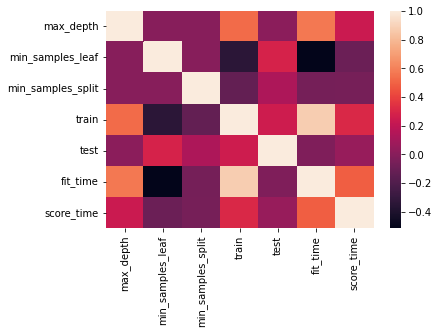

In [27]:
sns.heatmap(corr)

Or

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13efb70890>,
      dtype=object)

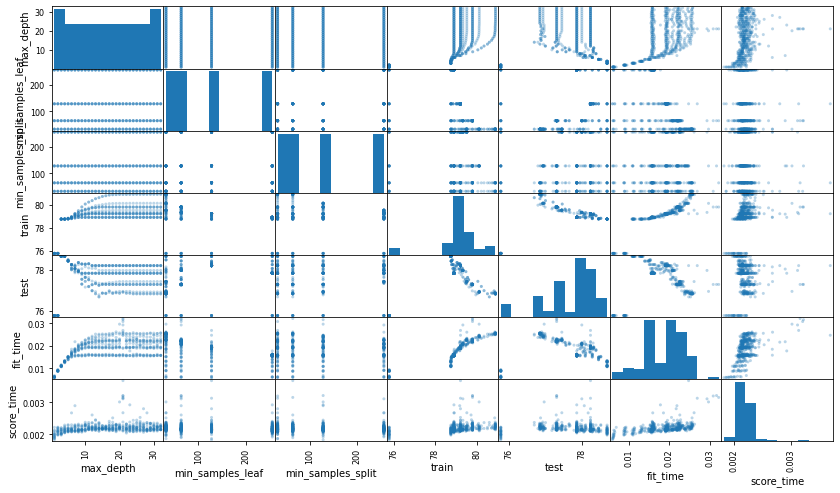

In [28]:
from pandas.plotting import scatter_matrix
scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

The diagonal shows th histogram of where the i took place

Or

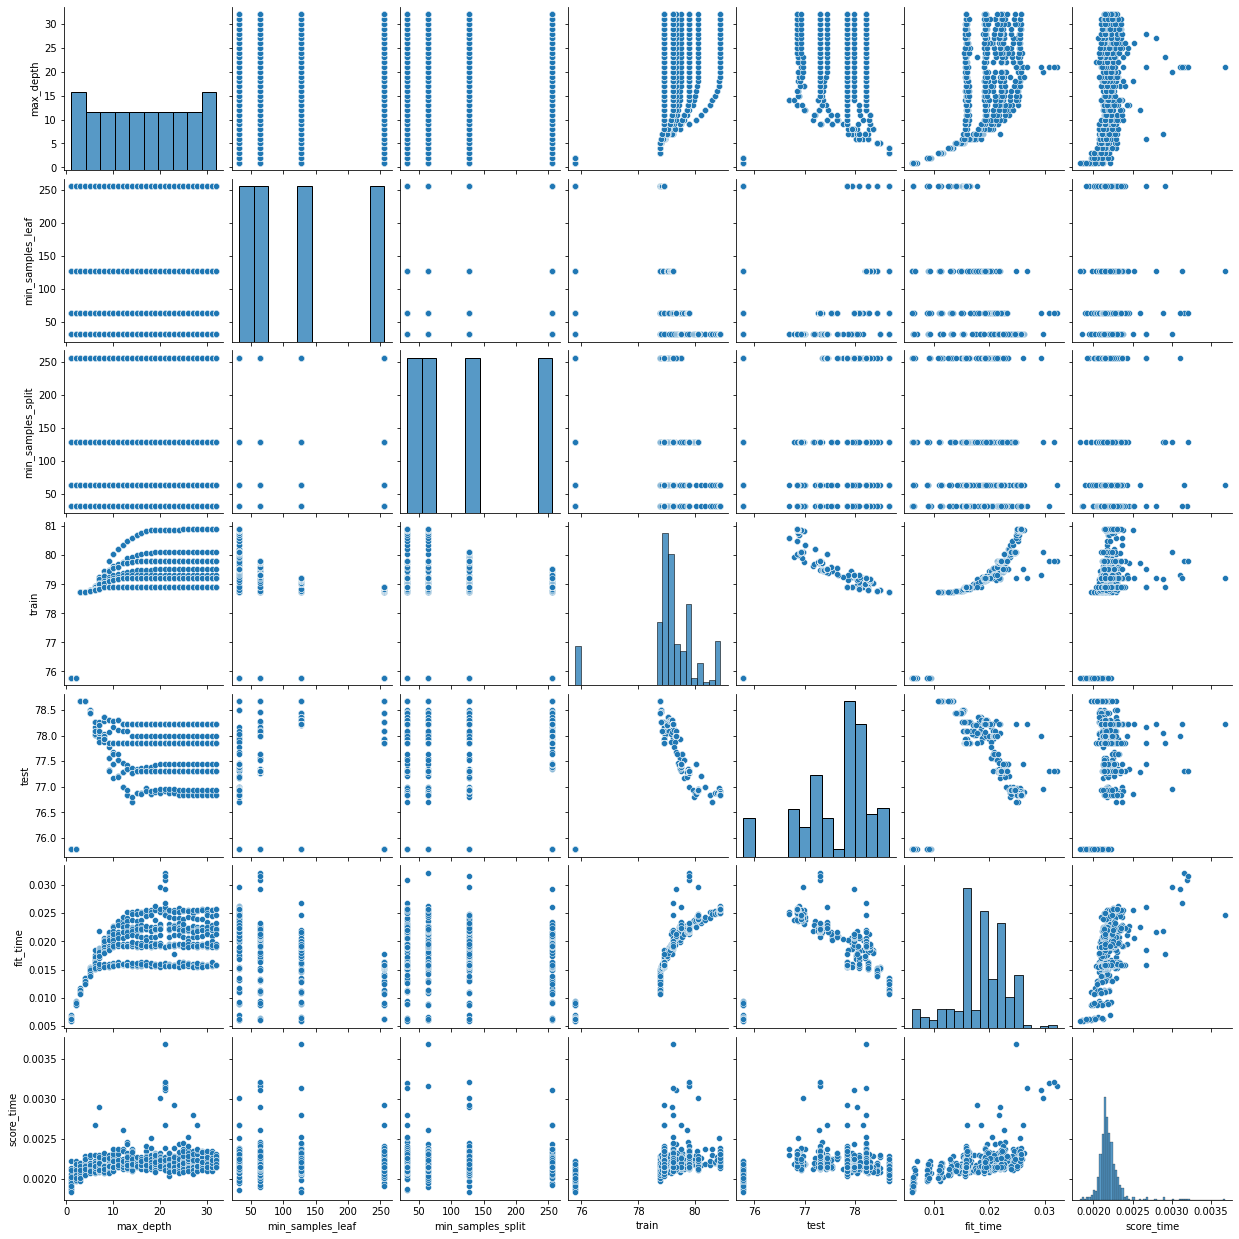

In [29]:
sns.pairplot(resultados) 

or

Our correlation shows positive corr between min_samples_leaf and test, so setting higher min_samples_leaf can reflect better results.

In [30]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf) # see we added the parameter min_sample_leaf here
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score] # see we also added min_sample_leaf here
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [31]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,6.863211e-17,0.354588,0.240852
min_samples_leaf,6.863211e-17,1.000000e+00,-0.637649,-0.440661
train,3.545878e-01,-6.376494e-01,1.000000,0.909222
test,2.408525e-01,-4.406611e-01,0.909222,1.000000


See now we have max_depth=3 as an important result

In [32]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


## Optimizing with several parameters - GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5], # we choose only 2 values for max_depth
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"] # another dimension

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011482,0.000870,0.002252,0.000379,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.011413,0.000369,0.002124,0.000080,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.011479,0.001172,0.002192,0.000287,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.011443,0.000722,0.002137,0.000170,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.010838,0.000081,0.001965,0.000056,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


Best estimator

In [34]:
best=busca.best_estimator_
best 

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

The best parameters are

In [35]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


# Predict model 

## Predict only

Given the model with the best parameters simulated previously, let test it. However such approach is biased. The accuracy is optimist as we are only predicted it only once. We need to do another cross-validation.

In [36]:
from sklearn.metrics import accuracy_score 

predicoes = best.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


## Nested cross validation 

When we use several parameters (hyper-parameters) we need to do a second cross-validation

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/

That's a bug from SKLearn, where is not possible to add GroupKFold to the previous code. 

Now we add shuffle and remove the groups

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011211,0.002377,0.002103,0.000105,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010395,0.000606,0.002281,0.000293,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010169,0.000196,0.002098,0.000069,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009975,0.000092,0.002081,0.000028,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.011023,0.001378,0.002480,0.000248,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


This is our model **accuracy** interval

In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [40]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy avg %.2f" % media)
  print("Interval [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [41]:
imprime_score(scores)

Accuracy avg 78.67
Interval [76.80, 80.54]


Visualize

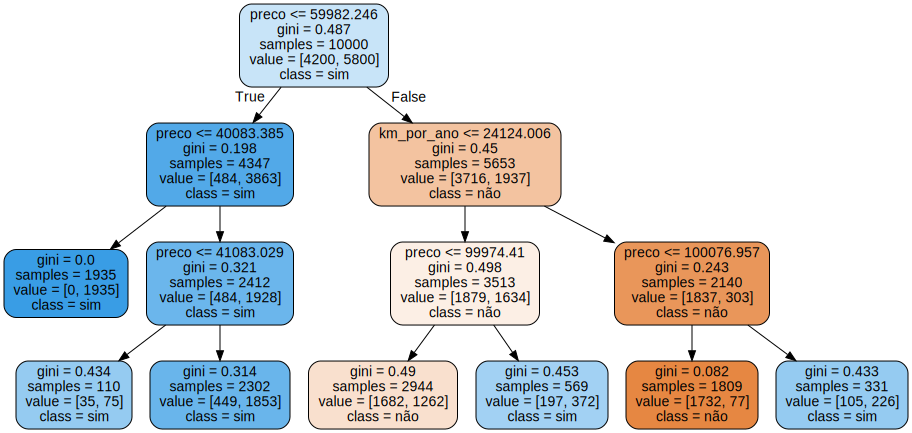

In [43]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(best, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Random search

So far we tested different values of the parameters in an exploratory manner. Such approach allows the exploration of an extensive range of values. However, such approach takes a lot of time. 

On the other hand, it is possible to random selects the values of the parameters.

Instead of using GridSearchCV now we will use RandomizedSearchCV

In [44]:
from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16, # before we ran 2*3*3*2 (max_depth*min_sample_split*...) combination of parameters
                    # now we are running 16 random combinations
                    cv = KFold(n_splits = 5),
                          random_state = SEED)

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014724,0.002458,0.002252,0.000137,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.4330,0.4525,0.771,0.742,0.7725,0.6342,0.156817,1
1,0.009944,0.000105,0.002109,0.000084,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
2,0.010230,0.000521,0.002376,0.000415,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
3,0.019735,0.000514,0.002291,0.000069,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5
4,0.019454,0.000480,0.002449,0.000413,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5


Accuracy interval:

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7755, 0.78  , 0.8055, 0.7855, 0.774 ])

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy avg 78.69
Interval [76.70, 80.68]


Best estimator

In [47]:
best=busca.best_estimator_
best 

DecisionTreeClassifier(max_depth=5, min_samples_leaf=128, min_samples_split=128)

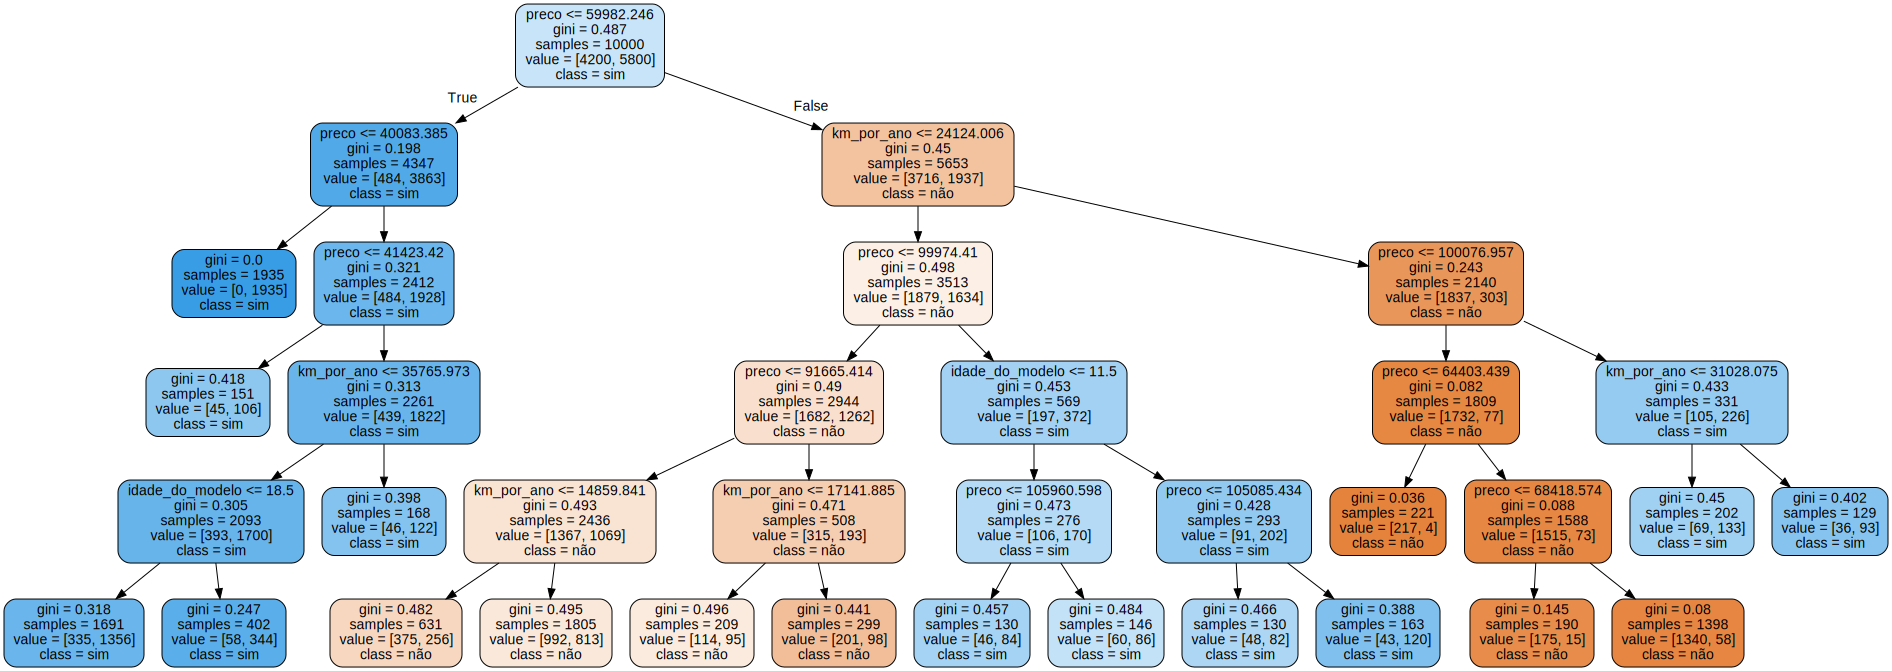

In [51]:
features = x_azar.columns
dot_data = export_graphviz(best, out_file=None, filled=True, rounded=True,
                        class_names=["não", "sim"],
                        feature_names = features)

graph = graphviz.Source(dot_data)
graph

Randomized and **random parameters**

Previously we set some values to the parameters.

In [52]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128), # randit sets random numbers between 32 and 128 (randit comes from scipy)
    "min_samples_leaf" : randint(32, 128), # randit generates random numbers every time is ran 
    "criterion" : ["gini", "entropy"]
# randit takes all values except one between the given range. Thus we have 7*96*96*2 combinations of these 4 parameters
# and we execute n_iter=16 of them. Before we were running 16 out of 2*3*3*2 combinations, now 16 out of 7*96*96*2 combinations
# running all these combinations instead of 16 samples of them is very time consuming and not feasible most of the times.
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025679,0.006260,0.006695,0.006303,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.028717,0.003541,0.004934,0.002675,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.025925,0.005880,0.003836,0.000230,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.030812,0.002173,0.004228,0.000643,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.019897,0.003014,0.002885,0.000931,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [53]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
best = busca.best_estimator_
print(best)

Accuracy avg 78.71
Interval [77.49, 79.93]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


Sort our previous dataframe

In [56]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
resultados_ordenados_pela_media.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025679,0.006260,0.006695,0.006303,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
6,0.020851,0.001081,0.002692,0.000508,entropy,5,73,72,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
12,0.013919,0.000372,0.002423,0.000383,gini,5,64,67,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
8,0.017181,0.000613,0.002305,0.000061,gini,10,108,110,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7760,0.7740,0.7970,0.7815,0.7765,0.7810,0.008373,4
13,0.017258,0.002136,0.002483,0.000484,gini,10,125,59,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7745,0.7745,0.7995,0.7790,0.7745,0.7804,0.009708,5


We can summarize the dataframe showing less info (below)

In [57]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +- (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +- (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +- (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +- (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +- (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +- (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +- (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +- (0.014) {'criterion': 'entropy', 

It is possible to increase the number of samples we get from the available combinations. But see below the accuracy is the same.

In [59]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128), 
    "min_samples_leaf" : randint(32, 128), 
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 64,
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)

In [60]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +- (0.024) {'criterion': 'gini', 'max_de

# RandomizedSearch vs GridSearchCV

## GridSearchCV

GridSearchCv using random forest (**ensemble RandomForestClassifier**) instead of the DecisionTree. While the latter uses only one tree, the random forest tries several trees. So in this case, in each fit you train several trees.

In [62]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100], # n_estimator parameter sets how many trees are created (the number of trees in the forest)
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
     "bootstrap" : [True, False], # instead of using the whole train data set, bootstrap takes samples of it. False means that the bootstrap cannot take the same elements over and over
    "criterion": ["gini", "entropy"] 
# you have more parameters to explore
}

tic = time.time() # we add tic and tac below to calculate the time (they could be potentially excluded from the code)
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f seconds" % tempo_que_passou)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 0.00 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043207,0.004565,0.005034,0.000185,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.374107,0.003483,0.028991,0.003918,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.040900,0.002769,0.004999,0.000189,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.368027,0.007397,0.027402,0.000978,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.043424,0.003413,0.005785,0.001007,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


See the best options

In [63]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


The code below won't run in Colab, maybe in your machine it will.

In [ ]:
#tic = time.time()
#scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
#tac = time.time()
#tempo_passado = tac - tic
#print("Tempo %.2f segundos" % tempo_passado)

#imprime_score(scores)
#melhor = busca.best_estimator_
#print(melhor)

## RamdomizedSearch

In [64]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 20, # while before in the GridSearch we explored 2*2*3*3*2*2 combinations, now we explore 20 random combinations
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 34.55 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.449516,0.012982,0.030772,0.003156,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.061869,0.004590,0.005436,0.000135,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.613783,0.006446,0.031842,0.001272,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.041606,0.002924,0.005103,0.000105,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.061237,0.003011,0.005260,0.000165,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


The best options:

In [65]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.776 +-(0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +-(0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


See the results are very similar

We can expect the following for our future (remember we couldn't even run this lines of code when using GridSearch)

In [66]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 158.15 segundos
Accuracy avg 77.59
Interval [76.47, 78.71]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


We can random our parameters instead (as did previously)

In [67]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]
# 91*3*(129-32)*(129-32)*2*2 combinations - this would never be ran in the GridSearch
# This is why we would run a randomize
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80, # the higher this number, more time it will take
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 119.45 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.384773,0.022429,0.027175,0.003730,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.293183,0.005410,0.023345,0.001151,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.284375,0.005120,0.022326,0.001295,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.189194,0.006241,0.015468,0.000720,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.282555,0.004309,0.021289,0.000924,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


See your best 5 estimators

In [68]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.778 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


Conclusion: The GridSearch will explore the whole space of your dimensions but will take a lot of time and memory/machine capacity. The randomizedSearch will give roughly similar results but with much less time.

# Working without cross-validation (only justifiable if you can't use it)

Now, instead of separating in train and test your data, you need to separate in 3 because you have 3 phases: Train one or several models -> Test each one of the models and see the better ones -> Validate phase where we validate the model and have its real estimation (with cross_val_score in the nested cross validation). 

Working without cross-validation we will divide the data in 3 groups (train, test anda validation set - validation set is the one we put aside to test our model trained and tested). We will use the shuffle stratified split.

We may want our sets such as 


*   0.6 of the data to train
*   0.2 to test (dev test)
*   0.2 to validate

The 0.2 below stands for the validation set


In [70]:
from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [73]:
espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25) # if you increase splits to 5 it will look more like the cross validation results

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 2.65 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.283249,0.0,0.022202,0.0,True,entropy,3,39,53,44,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7630,0.7630,0.0,2
1,0.136277,0.0,0.015262,0.0,True,gini,5,126,49,23,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7600,0.7600,0.0,4
2,0.410620,0.0,0.039388,0.0,False,gini,4,121,57,64,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7600,0.7600,0.0,4
3,0.548301,0.0,0.128894,0.0,True,gini,3,91,34,85,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7630,0.7630,0.0,2
4,0.718982,0.0,0.034590,0.0,True,gini,3,110,50,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7645,0.7645,0.0,1


To validate the model, we need to test it in a set of data new to it.

In [76]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

scores

Tempo 0.60 segundos


array([0.754])